## Source Information
---
**Title:**  Sequence Model Time Series Prediction Using Tensorflow 2.0
**Author/Source:**: https://medium.com/analytics-vidhya/sequence-model-time-series-prediction-using-tensorflow-2-0-665257beb25f

**Last Updated Date**: October 01, 2024 by Gloria Seo

**Resources**: https://medium.com/analytics-vidhya/sequence-model-time-series-prediction-using-tensorflow-2-0-665257beb25f

**Launched on Expanse: 03/22/2025**
galyleo launch --account abc123 --partition shared --cpus 1 --memory 4 --time-limit 01:30:00 --env-modules cpu/0.17.3b,anaconda3/2021.05,singularitypro --sif /cm/shared/apps/containers/singularity/tensorflow/tensorflow-latest.sif

---

## Goal
This Jupyter Notebook demonstrates how to build a simple time series forecasting model using TensorFlow. Specifically, we are working with historical data of the exchange rate between USD and INR (Indian Rupee), which we will download as a CSV file. The goal is to predict future values based on past trends using a sequential deep learning model.



In [1]:
#check host info:
!hostname
!nvidia-smi

exp-5-07
/bin/bash: line 1: nvidia-smi: command not found


# Downloading and Preparing the Data

We download a CSV file containing USD to INR exchange rates from the internet. This data will be stored locally and used to train the forecasting model.

In [2]:
# Download the CSV file using wget
!wget --no-check-certificate https://raw.githubusercontent.com/satishnaidu/mldata/master/timeseries/USD_INR.csv -O /tmp/USD_INR.csv

# Define the file path
file_path = '/tmp/USD_INR.csv'


--2025-03-23 15:55:58--  https://raw.githubusercontent.com/satishnaidu/mldata/master/timeseries/USD_INR.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130380 (127K) [text/plain]
Saving to: '/tmp/USD_INR.csv'

/tmp/USD_INR.csv    100%[===================>] 127.32K  --.-KB/s    in 0.005s  

2025-03-23 15:55:58 (24.9 MB/s) - '/tmp/USD_INR.csv' saved [130380/130380]



In [3]:
# check that file has been fully transferred
# if on interactive node, you need to run this command from that node.

!ls -al /tmp/USD_INR.csv


-rw-r--r-- 1 mthomas use300 130380 Mar 23 15:55 /tmp/USD_INR.csv


## Load Required Modules for the Jupyter Notebook
Before running the notebook, make sure to load these modules.

**Module: tensorflow, numpy, csv, matplotlib** 


In [4]:
import tensorflow as tf

2025-03-23 15:56:06.793468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-23 15:56:06.793539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-23 15:56:06.794313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 15:56:06.800175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import numpy as np
import matplotlib.pyplot as plt


## Plotting the Data
To better understand the dataset, we will first visualize the exchange rates over time. The CSV file is read, and the relevant columns (date and exchange rate) are extracted for plotting. A function plot_series() is used to neatly display the time series data.

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

71.515


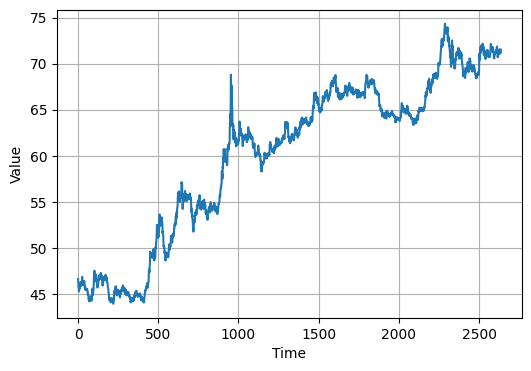

In [11]:
import csv
time_step = []
inr_conversion = []
with open(file_path, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        inr_conversion.append(float(row[2]))
        time_step.append(int(row[0]))
        
print(inr_conversion[len(time_step)-1])
series = np.array(inr_conversion)
time = np.array(time_step)
plt.figure(figsize=(6, 4))
plot_series(time, series)

This code visualizes the USD-INR exchange rate over time, giving a sense of how the currency value fluctuates. From this graph, you can notice that it has an upward trend but doesn’t have any specific seasonality and a lot of noise.

While working on Timeseries data, you have to familiar with the following terminologies.
* _Trend_: The increase or decrease of time series values
Eg: Upward trend or Downward trend.
* _Seasonality_: The repeated consistent pattern in the series
Eg: Temperatures in summer go up in the morning and goes down at night.
* _Noise_: Random values in the series, which make the model difficult to identify trend and seasonality.

## Splitting the Data

Next, we split the time-series data into two parts:

1. Training Data: Used to train the model.
2. Validation Data: Used to test how well the model performs on unseen data.


In [12]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000

## Creating a Tensorflow Model with Windowed Dataset 

Next, create a TensorFlow model with helper functions such as windowed dataset and model forecast functions.  A time series prediction model learns better when we provide it with small "windows" of data points. The windowed_dataset() function helps create batches of sequential data for training.

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

## Building the Model
The model is built using a sequential structure that includes:
* Convolutional Layers: Extracts patterns from the time series data.
* LSTM (Long Short-Term Memory) Layers: Excellent for learning from sequential data.
* Dense Layers: Final layers for producing the output predictions.

In [37]:
#record time before model training
import time
start_time=time.perf_counter()

In [38]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

tf.random.set_seed(51)
np.random.seed(51)  
 
train_set = windowed_dataset(x_train, window_size=120,
                             batch_size=100,
                             shuffle_buffer=shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                         strides=1,padding="causal",
                         activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=51e-7, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
19/19 [==============================] - 5s 150ms/step - loss: 11.8429 - mae: 12.3340
Epoch 2/100
19/19 [==============================] - 3s 153ms/step - loss: 7.0171 - mae: 7.5057
Epoch 3/100
19/19 [==============================] - 3s 139ms/step - loss: 7.5566 - mae: 8.0505
Epoch 4/100
19/19 [==============================] - 3s 143ms/step - loss: 2.9894 - mae: 3.4586
Epoch 5/100
19/19 [==============================] - 3s 146ms/step - loss: 1.2806 - mae: 1.7151
Epoch 6/100
19/19 [==============================] - 3s 144ms/step - loss: 1.2616 - mae: 1.6948
Epoch 7/100
19/19 [==============================] - 3s 158ms/step - loss: 1.1898 - mae: 1.6090
Epoch 8/100
19/19 [==============================] - 3s 141ms/step - loss: 1.4556 - mae: 1.9235
Epoch 9/100
19/19 [==============================] - 3s 143ms/step - loss: 1.3135 - mae: 1.7749
Epoch 10/100
19/19 [==============================] - 3s 141ms/step - loss: 1.3420 - mae: 1.7865
Epoch 11/100
19/19 [=================

Next, predict the forecast for every time series window
rnn == Recurrent Neural Network

Here we have defined the following:
* window size of 120 
* strides=1
forecast will try to predict the 120th value using the previous 119 values and move to 1 level next using stride value.

In [31]:
#calc time spent on model training
stop_time = time.perf_counter()
print("start_time: ", start_time)
print("stop_time: ", stop_time)
elaps_time_secs=stop_time-start_time
print("elaps_time_secs: ", elaps_time_secs)
print("elaps_time_mins: ", elaps_time_secs/60)

start_time:  647896.292107901
stop_time:  648597.060906563
elaps_time_secs:  700.7687986620003


In [32]:
#np.random.seed(51)  
rnn_forecast = model_forecast(model, series[..., np.newaxis],window_size)

81/81 [==============================] - 2s 15ms/step


In [33]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [34]:
#print array dimensions/shape
print("split_time: ",split_time)
print("window_size: ",window_size)
print("x_valid: ",x_valid.shape)
print("rnn_forecast: ", rnn_forecast.shape)

split_time:  2000
window_size:  60
x_valid:  (636,)
rnn_forecast:  (636,)


Finally, plot the predicted results against the original data for the validation set.

time_valid:  [2635]
rnn forcast:  [69.18609]


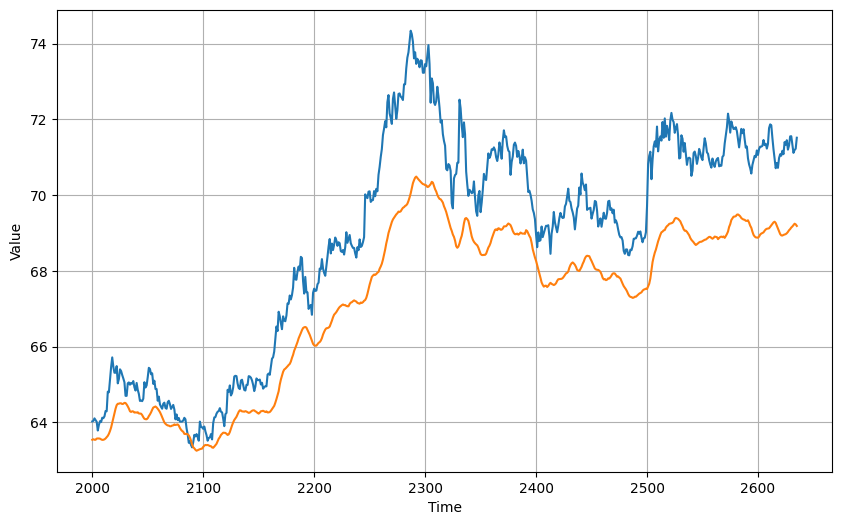

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print("time_valid: ",time_valid[-1:])
print("rnn forcast: ",rnn_forecast[-1:])
##??References:

In order to forecast future data, use the most recent 120 values from the input series to predict the next value.

In [36]:
split_time = 2515
window_size = 120
rnn_forecast = model_forecast(model, series[split_time:,np.newaxis],     window_size)
rnn_forecast = rnn_forecast[0:-1, -1, 0]
print("RNN Forecast: ",rnn_forecast)

1/1 [==============================] - 0s 31ms/step
RNN Forecast:  [69.25389]


## Last Updated Date and Resources
---
**Last Updated Date**: October 01, 2024

**Resources**: https://medium.com/analytics-vidhya/sequence-model-time-series-prediction-using-tensorflow-2-0-665257beb25f

---

## Submit Ticket
If you find anything that needs to be changed, edited, or if you would like to provide feedback or contribute to the notebook, please submit a ticket by contacting us at:

Email: consult@sdsc.edu

We appreciate your input and will review your suggestions promptly!